# 1. Install and import kfp and pip

In [ ]:
!python -m pip install --user --upgrade pip

In [ ]:
!pip3 install kfp --upgrade --user

**Please restart kernel before you proceed**

In [ ]:
import kfp
from kfp import dsl
import kfp.components as comp

# 2. Write python functions for each step in the ML Workflow.

In [ ]:
# create  directory for outputs.
output_dir = "/home/jovyan/KubeflowTraining/Day 2/KubeflowComponentsAndPipeline/Labs/3_TensorFlow_Example/store/"

### a. Defining the function that downloads the data from [storage](https://github.com/MavenCode/KubeflowTraining/tree/master/Data).

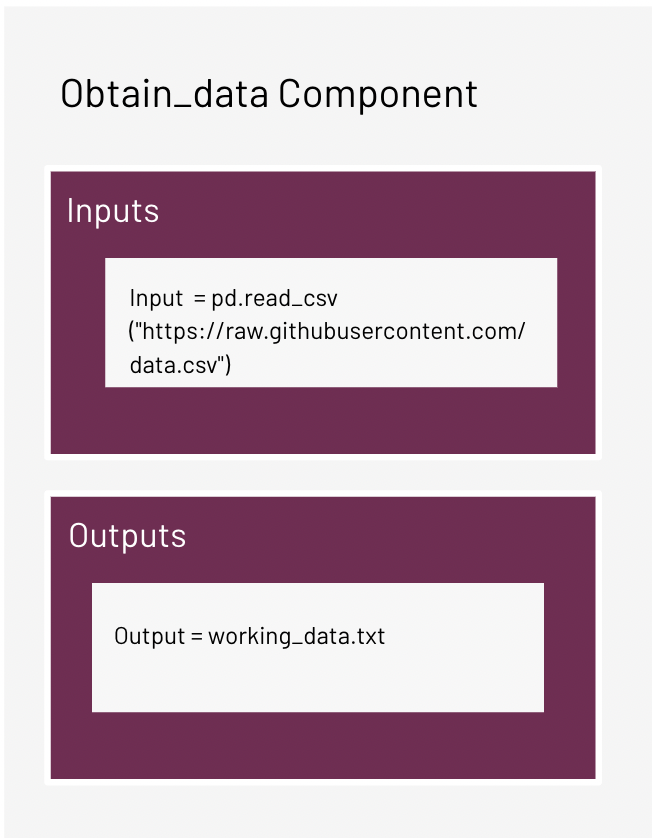

In [ ]:
def obtain_data(data_path, working_data):
    import pickle
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install','pandas==0.23.4'])
    import pandas as pd
    
     #reading the data from its source
    data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")
    #Save the data as a pickle file to be used by the preprocess component.
    with open(f'{data_path}/{working_data}', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
obtain_data(output_dir, "working_data")

### b. Defining the preprocess function

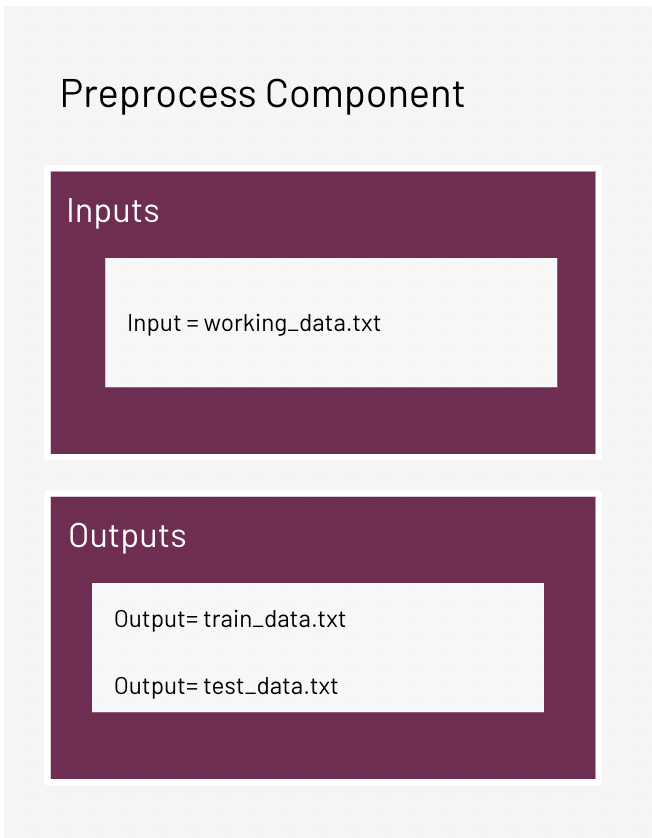

In [ ]:
def preprocess(data_path,working_data,train_data,test_data):
    import pickle
    # import Library
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install','scikit-learn==0.22'])
    subprocess.run([sys.executable, '-m', 'pip', 'install','pandas==0.23.4'])
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 

    #loading the working data
    with open(f'{data_path}/{working_data}', 'rb') as f:
        data = pickle.load(f)

    #dropping some columns that are not needed
    data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
    #data features
    X = data.iloc[:,:-1]
    #target data
    y = data.iloc[:,-1:]   
    #encoding the categorical columns
    le = LabelEncoder()
    ohe = OneHotEncoder()
    X['Gender'] = le.fit_transform(X['Gender'])
    geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

    #getting feature name after onehotencoding
    geo_df.columns = ohe.get_feature_names(['Geography'])

    #merging geo_df with the main data
    X = X.join(geo_df) 
    #dropping the old columns after encoding
    X.drop(columns=['Geography'], axis=1, inplace=True)

    #splitting the data 
    X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)
    #feature scaling
    sc =StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    #saving the values from the dataframe
    y_train = y_train.values
    y_test = y_test.values
    
    #Save the train_data as a pickle file to be used by the train component.
    with open(f'{data_path}/{train_data}', 'wb') as f:
        pickle.dump((X_train,  y_train), f)
        
    #Save the test_data as a pickle file to be used by the predict component.
    with open(f'{data_path}/{test_data}', 'wb') as f:
        pickle.dump((X_test,  y_test), f)
    
    return(print('Done!'))

In [ ]:
preprocess(output_dir,"working_data", "train_data","test_data")

### c. Defining the train function

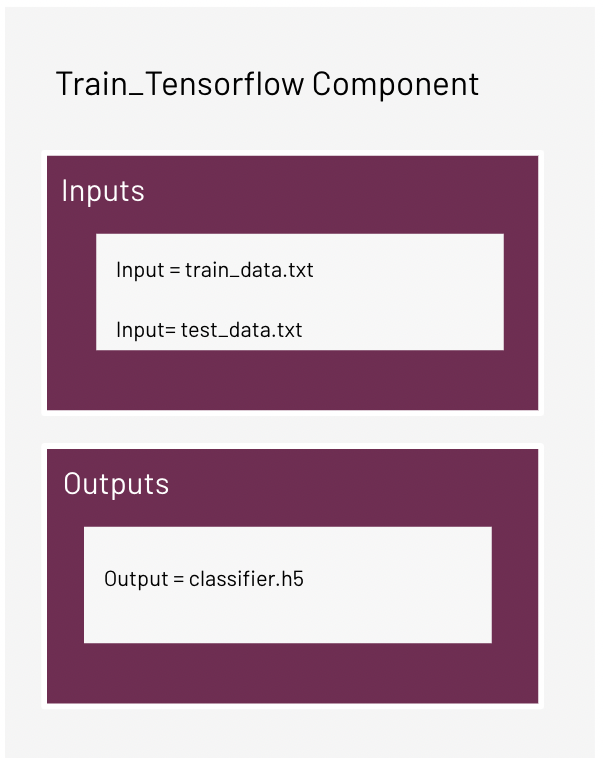

In [ ]:
def train_tensorflow(data_path,train_data, model):
    import pickle
    # import Library
    import numpy as np
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense

    #loading the train data
    with open(f'{data_path}/{train_data}', 'rb') as f:
        train_data = pickle.load(f)
    # Separate the X_train from y_train.
    X_train, y_train = train_data
    
    #initializing the classifier model with its input, hidden and output layers
    classifier = Sequential()
    classifier.add(Dense(units = 16, activation='relu', input_dim=12,))
    classifier.add(Dense(units = 8, activation='relu'))
    classifier.add(Dense(units = 1, activation='sigmoid'))
    #Compiling the classifier model with Stochastic Gradient Desecnt
    classifier.compile(optimizer = 'adam', loss='binary_crossentropy' , metrics =['accuracy'])
    #fitting the model
    classifier.fit(X_train, y_train, batch_size=10, epochs=20)
    #saving the model
    classifier.save(f'{data_path}/{model}')    

In [ ]:
train_tensorflow(output_dir, "train_data","model")

### d. Defining predict function

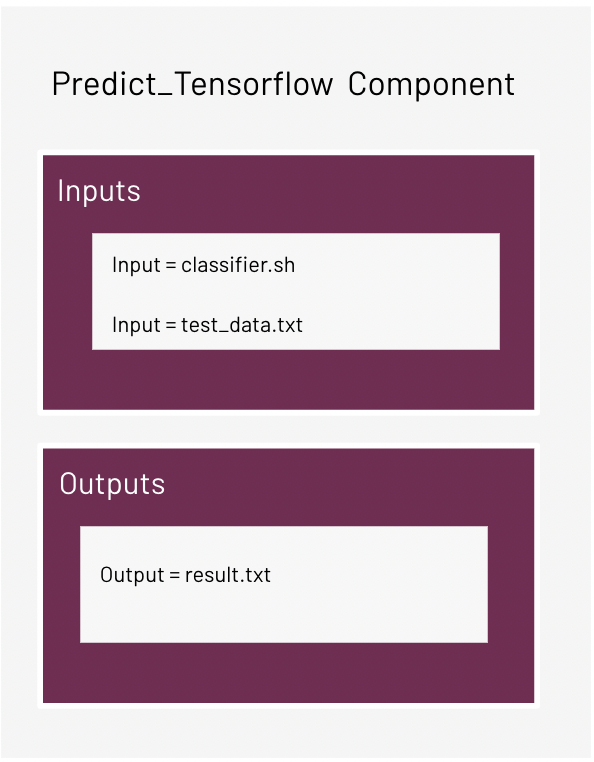

In [ ]:
def predict_tensorflow(data_path,test_data,model):
    import pickle
    import numpy as np
    from tensorflow import keras
    from tensorflow.keras.models import load_model
    
    #loading the X_test and y_test
    with open(f'{data_path}/{test_data}', 'rb') as f:
        test_data = pickle.load(f)
    # Separate the X_test from y_test.
    X_test, y_test = test_data
    #loading the model
    classifier = load_model(f'{data_path}/{model}')

    #Evaluate the model and print the results
    test_loss, test_acc = classifier.evaluate(X_test,  y_test, verbose=0)
    
    #model's prediction on test data
    y_pred = classifier.predict(X_test)
    # create a threshold for the confution matrics
    y_pred=(y_pred>0.5)

    #saving the test_loss and test_acc
    with open(f'{data_path}/performance.txt', 'w') as f:
        f.write("Test_loss: {}, Test_accuracy: {} ".format(test_loss,test_acc))

    #saving the predictions
    with open(f'{data_path}/results.txt', 'w') as result:
        result.write(" Prediction: {}, Actual: {} ".format(y_pred,y_test.astype(np.bool)))

In [ ]:
predict_tensorflow(output_dir,"test_data", "model")

# 3. Create Kubeflow components for each step from the python functions defined above .

In [ ]:
# create light weight components
obtain_data_op = kfp.components.create_component_from_func(obtain_data,base_image="python:3.7.1")
preprocess_op = kfp.components.create_component_from_func(preprocess,base_image="python:3.7.1")
train_op = kfp.components.create_component_from_func(train_tensorflow, base_image="tensorflow/tensorflow:latest-gpu-py3")
predict_op = kfp.components.create_component_from_func(predict_tensorflow, base_image="tensorflow/tensorflow:latest-gpu-py3")

# 4. Define the Kubeflow Pipeline

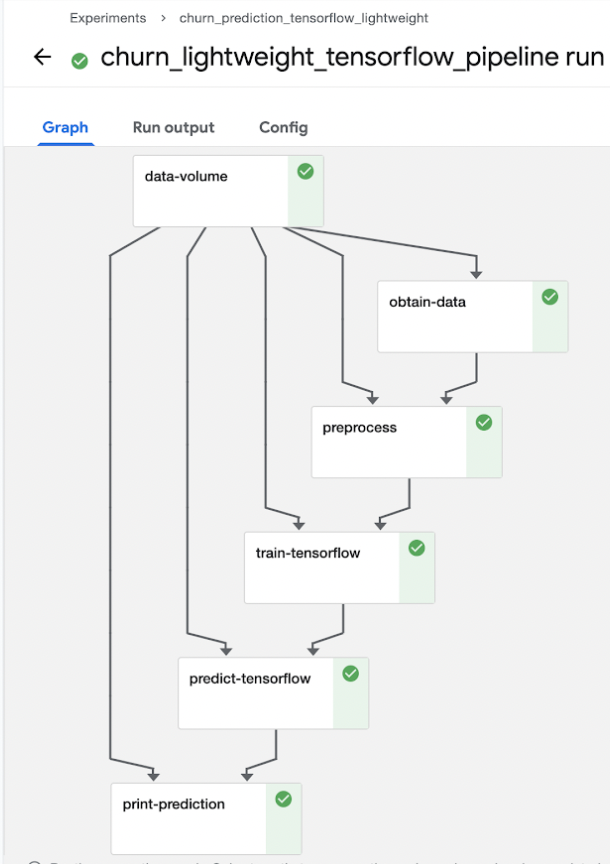

In [ ]:
# create client that would enable communication with the Pipelines API server 
client = kfp.Client()

In [ ]:
# define pipeline
@dsl.pipeline(name="Churn Pipeline", description="Performs Preprocessing, training and prediction of churn rate")

# Define parameters to be fed into pipeline
def churn_lightweight_tensorflow_pipeline(data_path: str,
                                          working_data: str,
                                         train_data: str,
                                         test_data:str,
                                         model:str):
    
    # Define volume to share data between components.
    volume_op = dsl.VolumeOp(
    name="data_volume",
    resource_name="data-volume",
    size="1Gi",
    modes=dsl.VOLUME_MODE_RWO)

    #create obtain data component
    obtain_data_container = obtain_data_op(data_path, working_data).add_pvolumes({data_path: volume_op.volume})
    # Create preprocess components.
    preprocess_container = preprocess_op(data_path, working_data, train_data, test_data).add_pvolumes({data_path: obtain_data_container.pvolume})
    # Create train component.
    train_container = train_op(data_path, train_data, model).add_pvolumes({data_path: preprocess_container.pvolume})
    # Create prediction component.
    predict_container = predict_op(data_path, test_data, model).add_pvolumes({data_path: train_container.pvolume})
    
    # Print the result of the prediction
    result_container = dsl.ContainerOp(
        name="print_prediction",
        image='library/bash:4.4.23',
        pvolumes={data_path: predict_container.pvolume},
        arguments=['cat', f'{data_path}/results.txt']
        )

# 5. Compile and Run the Kubeflow Pipeline

In [ ]:
DATA_PATH = '/mnt'
DATA = "working_data"
TRAIN_DATA = "train_data"
TEST_DATA = "test_data"
MODEL_FILE= "classifier.h5"


pipeline_func = churn_lightweight_tensorflow_pipeline

experiment_name = 'churn_prediction_tensorflow_lightweight'
run_name = pipeline_func.__name__ + ' run'

arguments = {"data_path":DATA_PATH,
             "working_data": DATA,
            "train_data": TRAIN_DATA,
            "test_data": TEST_DATA,
            "model":MODEL_FILE}

# Compile pipeline to generate compressed YAML definition of the pipeline.
kfp.compiler.Compiler().compile(pipeline_func,  
  '{}.zip'.format(experiment_name))

# Submit pipeline directly from pipeline function
run_result = client.create_run_from_pipeline_func(pipeline_func, 
                                                  experiment_name=experiment_name, 
                                                  run_name=run_name, 
                                                  arguments=arguments)


/home/jovyan/.local/lib/python3.6/site-packages/kfp/dsl/_container_op.py:1039: FutureWarning: Please create reusable components instead of constructing ContainerOp instances directly. Reusable components are shareable, portable and have compatibility and support guarantees. Please see the documentation: https://www.kubeflow.org/docs/pipelines/sdk/component-development/#writing-your-component-definition-file The components can be created manually (or, in case of python, using kfp.components.create_component_from_func or func_to_container_op) and then loaded using kfp.components.load_component_from_file, load_component_from_uri or load_component_from_text: https://kubeflow-pipelines.readthedocs.io/en/stable/source/kfp.components.html#kfp.components.load_component_from_file
  category=FutureWarning,
